In [1]:
import numpy as np

# General parameters
TIMESTEPS = 80  # Total number of timesteps
GRID_SIZE = 41  # 41x41 grid size
gray_background = 255  # Background grayscale value (255 means white)


# Function to dynamically generate rectangular moving block animations
def generate_moving_rectangles(step=2, move_speed=3):
    animations = {}
    
    # Loop through different width and height values, increasing by step each time until 41
    for width in range(1, GRID_SIZE + 1, step):
        for height in range(1, GRID_SIZE + 1, step):
            # Initialize an array of images with white background (255)
            images = np.ones((TIMESTEPS, GRID_SIZE, GRID_SIZE), dtype=np.uint8) * gray_background
            for t in range(TIMESTEPS):
                # The rectangle moves from left to right, with a speed of 2 grid cells per timestep
                start_x = max(0, t * move_speed - width)  # Calculate the starting x position based on the timestep and move speed
                end_x = min(t * move_speed, GRID_SIZE)  # Calculate the ending x position, ensuring it stays within grid bounds
                start_y = GRID_SIZE // 2 - height // 2  # Center the rectangle vertically
                end_y = start_y + height  # Calculate the ending y position
                
                # Ensure the rectangle stays within the grid range
                if end_x > start_x:
                    images[t, start_y:end_y, start_x:end_x] = 0  # Set the rectangle area to black (0)
            animations[(width, height)] = images  # Store the generated image array in the dictionary
    
    return animations

# Generate all animations
moving_rectangles_animations = generate_moving_rectangles()

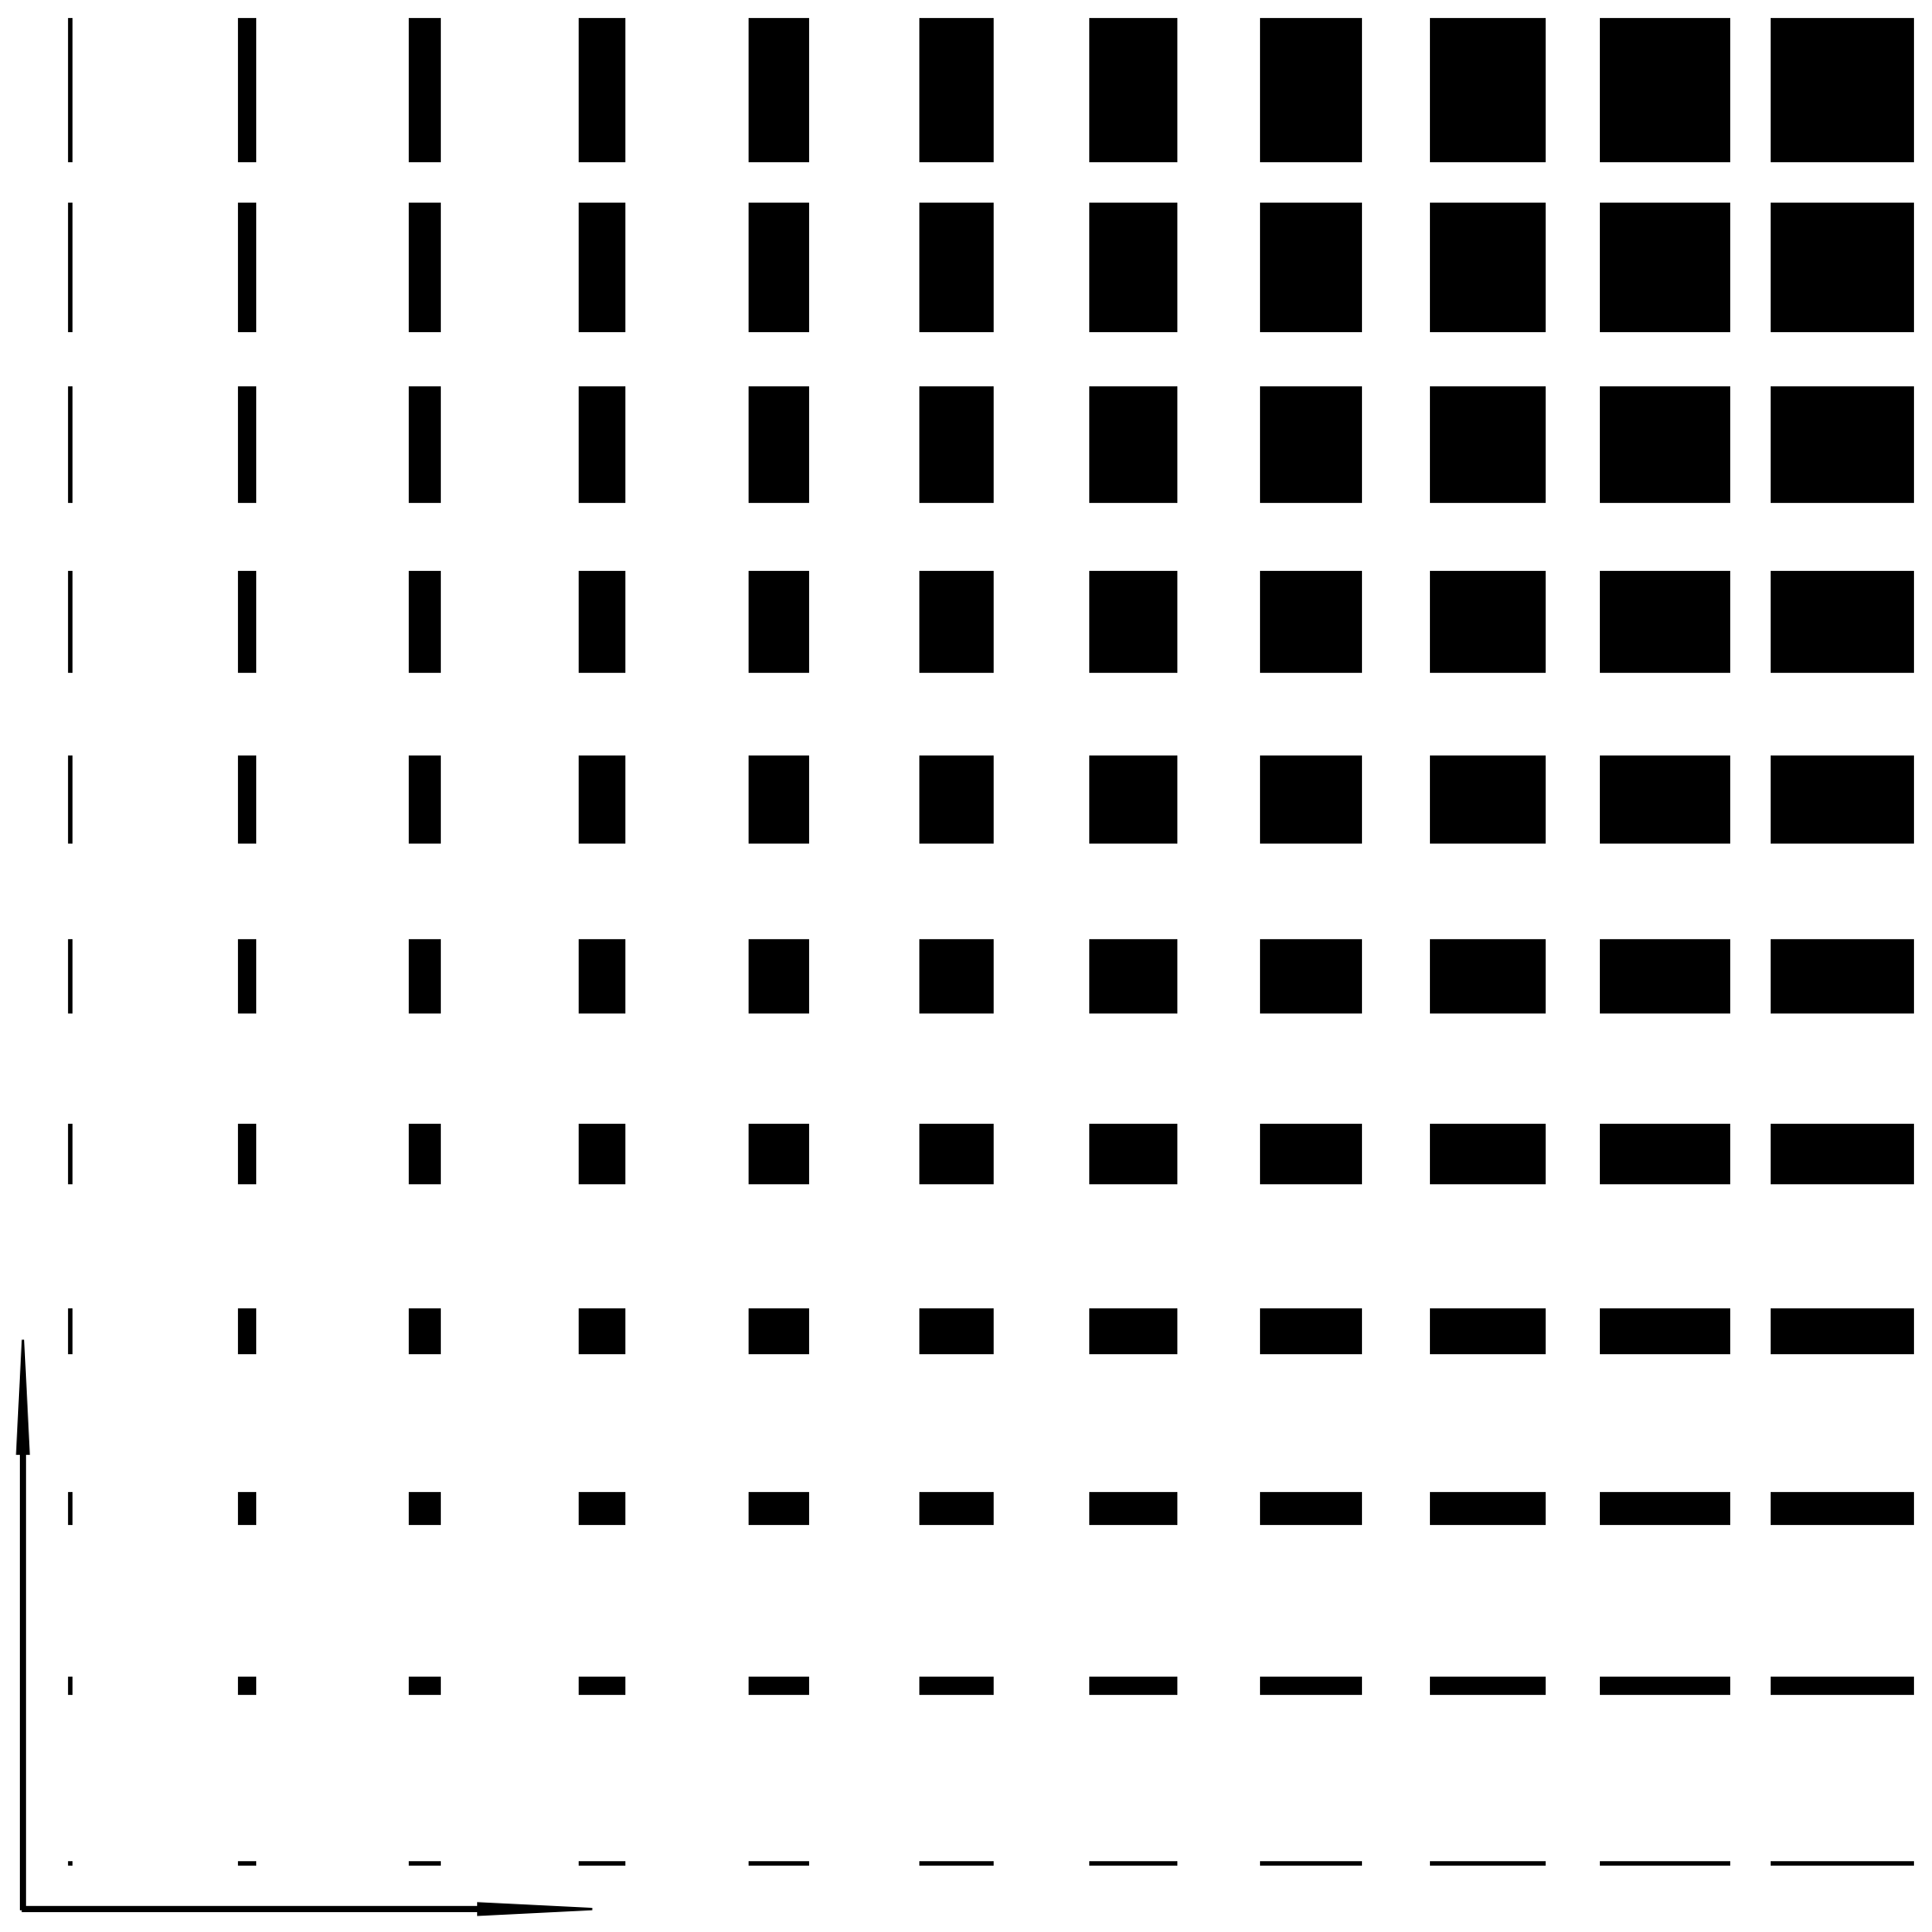

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Generate moving rectangle animations
moving_rectangles_animations = generate_moving_rectangles()

# Extract the range of widths and heights
widths = sorted(set(key[0] for key in moving_rectangles_animations.keys()))[:11]  # Get the first 11 unique widths
heights = sorted(set(key[1] for key in moving_rectangles_animations.keys()))[:11]  # Get the first 11 unique heights

# Create subplots
n_rows, n_cols = 11, 11  # Set number of rows and columns for the grid
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols, n_rows), dpi=200)  # Create a grid of subplots

# Loop over heights and widths to add rectangles to each subplot
for i, height in enumerate(reversed(heights)):  # Heights are arranged from bottom to top
    for j, width in enumerate(widths):
        ax = axes[i, j]
        rect = patches.Rectangle((0, 0), width, height, facecolor="black", edgecolor="white")  # Create black rectangle
        ax.add_patch(rect)  # Add the rectangle to the subplot
        ax.set_xlim(0, max(widths))  # Set x-axis limits
        ax.set_ylim(0, max(heights))  # Set y-axis limits
        ax.set_aspect('equal', adjustable='box')  # Ensure the aspect ratio is equal for square-shaped cells
        ax.axis('off')  # Hide the axis

# Add short arrows to indicate X and Y axes
arrow_length = 0.3  # Arrow length for X and Y axes

# Add X-axis arrow
fig.add_artist(plt.Arrow(-0.01, -0.01, arrow_length, 0, width=0.01, color="black"))
# Add Y-axis arrow
fig.add_artist(plt.Arrow(-0.01, -0.01, 0, arrow_length, width=0.01, color="black"))

# Adjust layout to prevent overlap and ensure clarity
plt.tight_layout(pad=1.0)

# Display the plot
plt.show()


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Parameter settings
HPF_TAU = 40  # Time constant for the high-pass filter
HPF_K = np.exp(-1 / HPF_TAU)  # EMA decay constant (calculated from the time constant)

def apply_high_pass_filter(images):
    """
    Apply a high-pass filter to a sequence of images (i.e., an animation).
    The high-pass filter emphasizes the changes between consecutive frames.
    """
    time_length = len(images)  # Get the number of frames in the sequence
    images_array = np.array(images, dtype=np.int16)  # Convert images to int16 type array for precision
    hpf = np.zeros_like(images_array, dtype=np.int16)  # Create an empty array to store the filtered images

    for t in range(1, time_length):
        # High-pass filter formula: subtract previous frame and apply exponential smoothing
        hpf[t] = (1.0 - HPF_K) * (images_array[t] - images_array[t - 1]) + HPF_K * hpf[t - 1]

    return hpf

# Apply the high-pass filter to each animation sequence
hpf_animations = {}
for size, images in moving_rectangles_animations.items():
    hpf_animations[size] = apply_high_pass_filter(images)


In [4]:
# Define a function to calculate L2 (only keep negative values in hpf and make them positive by taking the opposite sign)
def calculate_L2(hpf_data):
    """
    Calculate L2 by keeping only the negative values from the high-pass filtered data (convert them to positive).
    """
    return -np.minimum(hpf_data, 0.0)  # Take the minimum to select negative values, then negate them to make them positive

def calculate_L1(hpf_data):
    """
    Calculate L1 by keeping only the positive values from the high-pass filtered data.
    """
    return np.maximum(hpf_data, 0.0)  # Keep positive values, and set negative ones to zero

# Apply the L2 calculation to each filtered animation sequence
L2_animations = {}
for size, hpf_images in hpf_animations.items():
    L2_animations[size] = calculate_L2(hpf_images)

# Apply the L1 calculation to each filtered animation sequence
L1_animations = {}
for size, hpf_images in hpf_animations.items():
    L1_animations[size] = calculate_L1(hpf_images)


In [5]:
import matplotlib.pyplot as plt
import numpy as np

def heatmap_LC(LC_results_dict):
    """
    Plot heatmaps for multiple LC results. Each LC result will be placed in a subplot and globally normalized to the maximum value of 100%.
    Only the top-left 11x11 data is used.
    """
    # Set font style
    plt.rcParams["font.family"] = "Times New Roman"

    # Initialize global max value
    global_max = 0

    # Filter the data and calculate the global maximum
    filtered_results = {}
    for LC_name, LC_results in LC_results_dict.items():
        # Filter only the top-left 11x11 data
        filtered_results[LC_name] = {k: v for k, v in LC_results.items() if k[0] <= 11 and k[1] <= 11}
        for size_key, values in filtered_results[LC_name].items():
            peak_value = max(values)
            global_max = max(global_max, peak_value)

    # Subplot grid settings
    n_results = len(filtered_results)
    n_cols = 3
    n_rows = -(-n_results // n_cols)  # Calculate the number of rows (round up)

    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 6 * n_rows), constrained_layout=False)
    axes = axes.flatten()

    # Adjust subplot layout and colorbar position
    fig.subplots_adjust(right=0.85, hspace=0.5, wspace=0.5)  # Adjust spacing between subplots and right margin

    # Loop over each LC result and plot the heatmap
    for idx, (LC_name, LC_results) in enumerate(filtered_results.items()):
        # Current subplot
        ax = axes[idx]

        # Set fixed range for 11x11 grid
        object_angles = [2 * x - 1 for x in range(1, 12)]  # X-axis values: 2x - 1
        object_heights = [2 * x - 1 for x in range(1, 12)]  # Y-axis values: 2x - 1
        response_matrix = np.zeros((11, 11))  # Initialize response matrix

        # Fill the response matrix and normalize
        for i, height in enumerate(object_heights):
            for j, angle in enumerate(object_angles):
                size_key = (angle, height)
                if size_key in LC_results:
                    response_matrix[10 - i, j] = max(LC_results[size_key]) / global_max * 100  # Invert Y-axis

        # Plot contour-filled heatmap
        contour = ax.contourf(
            object_angles,
            object_heights,
            response_matrix,
            levels=10,
            cmap='plasma'
        )

        # Set ticks and labels
        ax.set_xticks(object_angles)  # Show each tick on X-axis
        ax.set_yticks(object_heights)  # Show each tick on Y-axis
        ax.tick_params(axis='both', which='major', labelsize=16, width=2, direction='in')
        ax.set_xticklabels(object_angles)
        ax.set_yticklabels(object_heights[::-1])  # Reverse Y-axis labels

        # Set border width
        for spine in ax.spines.values():
            spine.set_linewidth(2)

        # Set title
        ax.set_title(f"{LC_name}", fontsize=40)

        # Invert Y-axis to have (1,1) at the bottom-left
        ax.invert_yaxis()

    # Hide excess subplots
    for ax in axes[len(filtered_results):]:
        ax.axis('off')

    # Add colorbar
    cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])  # Add colorbar to the right
    cbar = fig.colorbar(contour, cax=cbar_ax)
    cbar.ax.tick_params(labelsize=16, width=2)  # Set colorbar tick size and line width
    cbar.set_label("Normalized Fmax (%)", fontsize=16)

    # Adjust layout to avoid overlap
    plt.tight_layout(rect=[0, 0, 0.88, 1])  # Ensure subplots are not squeezed by colorbar
    plt.show()


def plot_gaussian_kernels(kernels, title="Gaussian Kernels", n_rows=1, n_cols=1):
    """
    Plot multiple Gaussian kernels as heatmaps. Each kernel will be displayed in a separate subplot.
    """
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))
    fig.suptitle(title, fontsize=16)

    # Ensure axes is a list
    if n_rows * n_cols == 1:
        axes = [axes]

    # Loop over the kernels and plot each one
    for ax, (name, kernel) in zip(axes, kernels.items()):
        im = ax.imshow(kernel, cmap="viridis", interpolation="nearest", extent=(-20, 20, -20, 20))
        ax.set_title(name, fontsize=12)
        ax.set_xticks(np.arange(-20, 21, 5))
        ax.set_yticks(np.arange(-20, 21, 5))
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.grid(True, linestyle='--', alpha=0.6)
        fig.colorbar(im, ax=ax, shrink=0.7)

    # Hide excess subplots
    for ax in axes[len(kernels):]:
        ax.axis('off')

    # Adjust layout to avoid overlap
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [6]:
# Define constants
FDSR_TAU_FAST = 1
FDSR_TAU_SLOW = 10
FSR_K_FAST = np.exp(-1 / FDSR_TAU_FAST)
FSR_K_SLOW = np.exp(-1 / FDSR_TAU_SLOW)

def calculate_Tm9(L2, timesteps, height, width):
    
    # Initialize output arrays
    Tm9_FDSR_k = np.where((L2[1:, :, :] - L2[:-1, :, :]) > 0.0, FSR_K_FAST, FSR_K_SLOW)
    Tm9 = np.zeros((timesteps, height, width))

    # Apply low-pass filters to calculate Tm9 over time
    for t in range(2, timesteps):
        Tm9[t] = ((1.0 - Tm9_FDSR_k[t - 2]) * L2[t - 1]) + (Tm9_FDSR_k[t - 2] * Tm9[t - 1]) 

    return Tm9

Tm9_animations = {}
for size, L2_images in L2_animations.items():
    timesteps, height, width = L2_images.shape
    Tm9_animations[size] = calculate_Tm9(L2_images, timesteps, height, width)

Tm1_animations = L2_animations
Tm2_animations = L2_animations
Tm3_animations = L1_animations
Tm4_animations = L2_animations


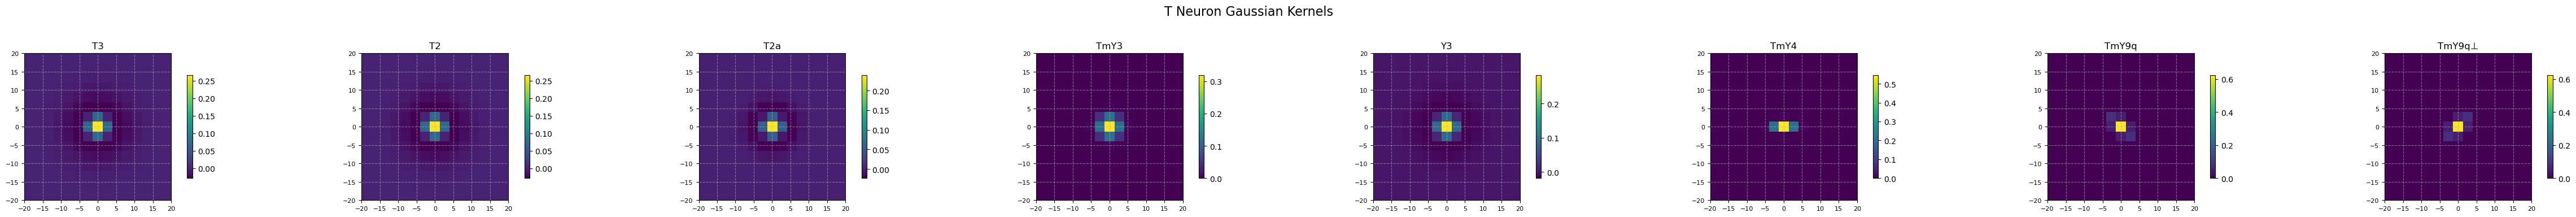

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import os


def create_gaussian_kernel(sigma_x=1, sigma_y=1, angle=0, size=15):
    ax = np.linspace(-(size // 2), size // 2, size)
    x, y = np.meshgrid(ax, ax)

    # Rotate coordinates
    theta = np.radians(angle)
    x_rot = x * np.cos(theta) + y * np.sin(theta)
    y_rot = -x * np.sin(theta) + y * np.cos(theta)

    # Create Gaussian kernel
    kernel = np.exp(-(x_rot**2 / ( sigma_x**2) + y_rot**2 / ( sigma_y**2)))
    kernel /= np.sum(kernel)  # Normalize to ensure the kernel sum is 1
    return kernel


# Generate kernels based on descriptions
kernels = {
    "T3": create_gaussian_kernel(sigma_x=1, sigma_y=1) - 1.5 * create_gaussian_kernel(sigma_x=3, sigma_y=3),
    "T2": create_gaussian_kernel(sigma_x=1, sigma_y=1) - 1.5 * create_gaussian_kernel(sigma_x=3, sigma_y=3),
    "T2a": create_gaussian_kernel(sigma_x=1, sigma_y=1) - 1 * create_gaussian_kernel(sigma_x=2, sigma_y=2),
    "TmY3": create_gaussian_kernel(sigma_x=1, sigma_y=1),
    "Y3": create_gaussian_kernel(sigma_x=1, sigma_y=1) - create_gaussian_kernel(sigma_x=3, sigma_y=3),
    "TmY4": create_gaussian_kernel(sigma_x=1, sigma_y=0.5, angle=0),
    "TmY9q": create_gaussian_kernel(sigma_x=1, sigma_y=0.5, angle=45),
    "TmY9q⊥": create_gaussian_kernel(sigma_x=1, sigma_y=0.5, angle=135),
}

# Set up subplot grid
plot_gaussian_kernels(kernels, title="T Neuron Gaussian Kernels", n_rows=1, n_cols=8)


In [8]:
from scipy.ndimage import convolve

# Initialize result dictionary to store convolution results
convolved_results = {kernel_name: {} for kernel_name in kernels.keys()}

# Apply each kernel to the L2 animation sequence
for size, L2_images in L2_animations.items():
    timesteps, height, width = L2_images.shape
    for kernel_name, kernel in kernels.items():
        # Initialize an array to store the convolution result for this kernel
        convolved_results[kernel_name][size] = np.zeros_like(L2_images)

        # Apply convolution for each time step
        for t in range(timesteps):
            convolved_results[kernel_name][size][t] = convolve(L2_images[t], kernel, mode='constant', cval=0.0)
            
# Initialize result dictionary to store convolution results for L1 images
convolved_results1 = {kernel_name: {} for kernel_name in kernels.keys()}

# Apply each kernel to the L1 animation sequence
for size, L1_images in L1_animations.items():
    timesteps, height, width = L1_images.shape
    for kernel_name, kernel in kernels.items():
        # Initialize an array to store the convolution result for this kernel
        convolved_results1[kernel_name][size] = np.zeros_like(L1_images)

        # Apply convolution for each time step
        for t in range(timesteps):
            convolved_results1[kernel_name][size][t] = convolve(L1_images[t], kernel, mode='constant', cval=0.0)


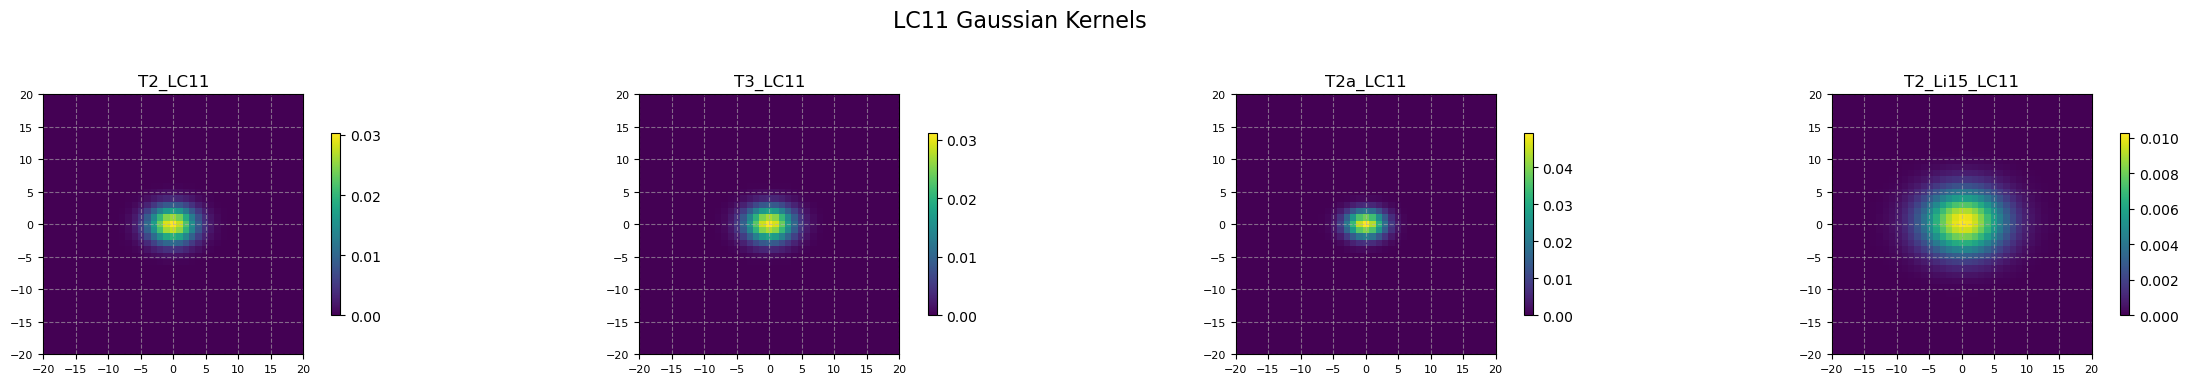

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import os

def create_gaussian_kernel_from_params(A, mu_x, mu_y, sigma_x, sigma_y, size=41):
    # Create a grid
    ax = np.linspace(-(size // 2), size // 2, size)
    x, y = np.meshgrid(ax, ax)
    
    # Generate Gaussian kernel
    kernel = A * np.exp(-(((x - mu_x)**2) / ( sigma_x**2) + ((y - mu_y)**2) / ( sigma_y**2)))
    kernel /= np.sum(kernel)  # Normalize
    return kernel

# Define parameters for Gaussian kernels
lc11_gaussian_params = {
    'T2_LC11': {'A': 0.016087013622013605, 'mu_x': -0.13760546727771442, 'mu_y': 0.11335302496547359, 
                'sigma_x': 3.716951856580259, 'sigma_y': 2.8203513069319524},
    'T3_LC11': {'A': 0.01642402741551777, 'mu_x': 0.058260160558346166, 'mu_y': 0.009257026035540109, 
                'sigma_x': 3.7609985770746204, 'sigma_y': 2.7205519467893393},
    'T2a_LC11': {'A': 0.025196046171514767, 'mu_x': -0.0733692598955412, 'mu_y': 0.04412542381516883, 
                 'sigma_x': 3.049755924731927, 'sigma_y': 2.117665735541721},
    'T2_Li15_LC11': {'A': 0.005603031553322903, 'mu_x': 0.22617863114548478, 'mu_y': -0.30347881030362206, 
                     'sigma_x': 6.342110203546551, 'sigma_y': 4.871036470984641}
}

# Generate kernels
LC11_kernels = {name: create_gaussian_kernel_from_params(**params) for name, params in lc11_gaussian_params.items()}

# Plot the kernels
plot_gaussian_kernels(LC11_kernels, title="LC11 Gaussian Kernels", n_rows=1, n_cols=4)

In [10]:
LC11_results = {}

for size, L2_convolved_images in convolved_results['T2'].items():
    timesteps, height, width = L2_convolved_images.shape
    
    LC11_results[size] = np.zeros(timesteps)

    for t in range(timesteps):
        weighted_sum = (
            0.26 * np.sum((convolved_results['T3'][size][t] + convolved_results1['T3'][size][t]) * LC11_kernels['T3_LC11']) +
            0.08 * np.sum((convolved_results['T2'][size][t] + convolved_results1['T2'][size][t]) * LC11_kernels['T2_LC11']) -
            0.08* np.sum((convolved_results['T2'][size][t] + convolved_results1['T2'][size][t]) * LC11_kernels['T2_Li15_LC11'])
        )
        LC11_results[size][t] = weighted_sum


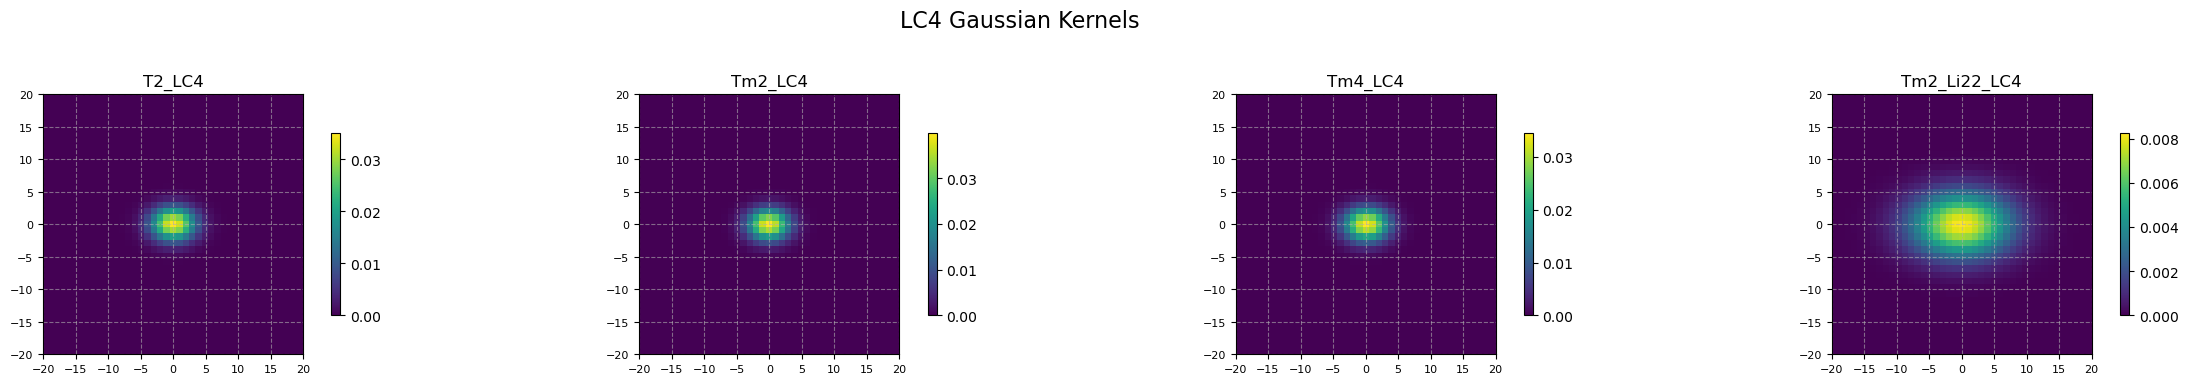

In [11]:
# LC4 Gaussian parameters
lc4_gaussian_params = {
    'T2_LC4': {'A': 0.018513809048837246, 'mu_x': 0.054096311785315605, 'mu_y': 0.008523544222943595, 
               'sigma_x': 3.4807361906839693, 'sigma_y': 2.616484464259377},
    'Tm2_LC4': {'A': 0.02190903676319083, 'mu_x': -0.05394101305364264, 'mu_y': 0.11412399118711397, 
                'sigma_x': 3.263629530779502, 'sigma_y': 2.4430368713529083},
    'Tm4_LC4': {'A': 0.018667265111389834, 'mu_x': 0.08794526088371826, 'mu_y': 0.12160987449984162, 
                'sigma_x': 3.519932580619196, 'sigma_y': 2.614902028364438},
    'Tm2_Li22_LC4': {'A': 0.0045380649031923235, 'mu_x': -0.10023876174833643, 'mu_y': 0.12002150844340005, 
                     'sigma_x': 7.750228389083664, 'sigma_y': 4.980194060026573}
}

# Generate Gaussian kernels for LC4
LC4_kernels = {name: create_gaussian_kernel_from_params(**params) for name, params in lc4_gaussian_params.items()}

plot_gaussian_kernels(LC4_kernels, title="LC4 Gaussian Kernels", n_rows=1, n_cols=4)

In [12]:
LC4_results = {}

for size, L2_convolved_images in convolved_results['T2'].items():
    timesteps, height, width = L2_convolved_images.shape
    
    LC4_results[size] = np.zeros(timesteps)

    for t in range(timesteps):
        weighted_sum = (
            0.23 * np.sum((convolved_results['TmY3'][size][t] + convolved_results1['TmY3'][size][t]) * LC4_kernels['T2_LC4']) +
            0.08 * np.sum((Tm2_animations[size][t]) * LC4_kernels['Tm2_LC4']) +
            0.08 * np.sum((Tm4_animations[size][t]) * LC4_kernels['Tm4_LC4']) +
            0.18 * np.sum((convolved_results['T2'][size][t] + convolved_results1['T2'][size][t]) * LC4_kernels['T2_LC4']) -
            0.07 * np.sum((Tm2_animations[size][t]) * LC4_kernels['Tm2_Li22_LC4']) 
        )
        LC4_results[size][t] = weighted_sum

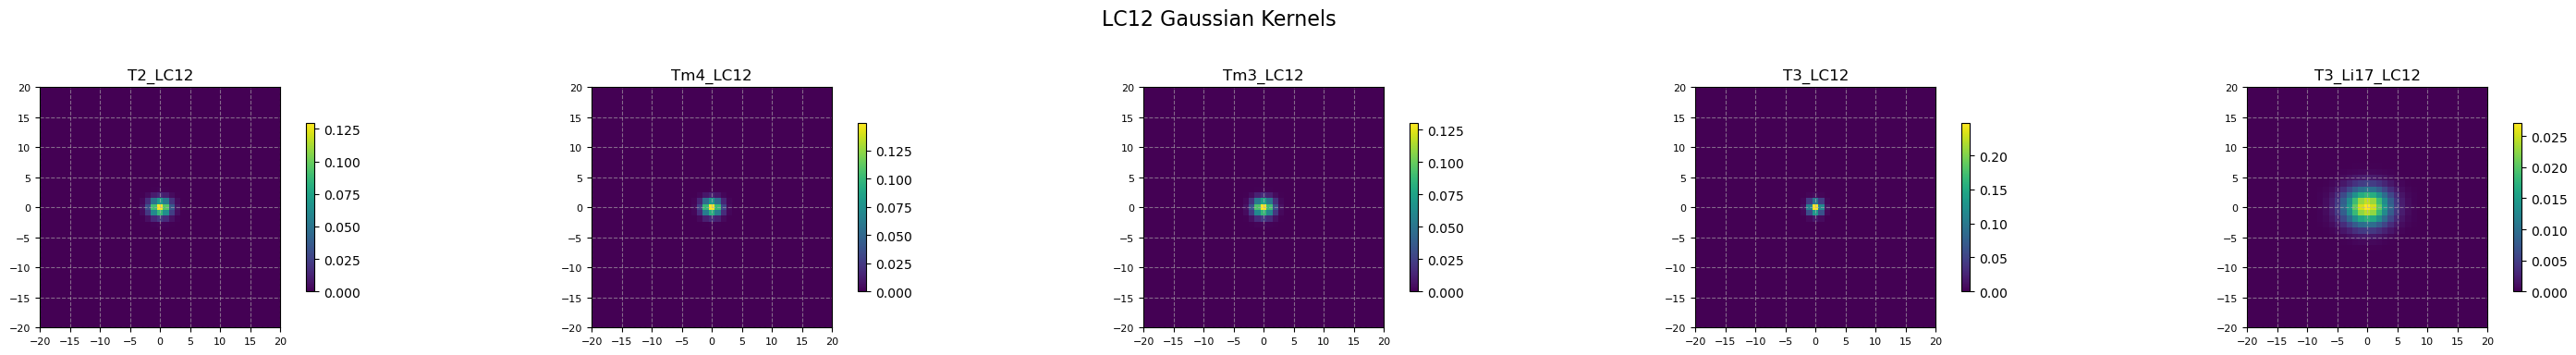

In [13]:
# LC12 Gaussian parameters
lc12_gaussian_params = {
    'T2_LC12': {'A': 0.06641826386396342, 'mu_x': 0.039024688757947894, 'mu_y': 0.10262580798423097, 
                'sigma_x': 1.7270439633049106, 'sigma_y': 1.4163365759157482},
    'Tm4_LC12': {'A': 0.0784081691606213, 'mu_x': 0.0015930201222432373, 'mu_y': 0.08118234959358771, 
                 'sigma_x': 1.5754422127561045, 'sigma_y': 1.348221467689174},
    'Tm3_LC12': {'A': 0.06853246415343084, 'mu_x': -0.03152815295703715, 'mu_y': 0.07658889963369184, 
                 'sigma_x': 1.6898701338158273, 'sigma_y': 1.4439000865480427},
    'T3_LC12': {'A': 0.12845784326194765, 'mu_x': 0.015225526024539403, 'mu_y': 0.10355430407635456, 
                'sigma_x': 1.1269415660743514, 'sigma_y': 1.1326247072051248},
    'T3_Li17_LC12': {'A': 0.014546699134548226, 'mu_x': -0.004596357869558654, 'mu_y': -0.03729625251632292, 
                     'sigma_x': 3.8154355313057735, 'sigma_y': 3.0820594144848332}
}

# Generate Gaussian kernels for LC12
LC12_kernels = {name: create_gaussian_kernel_from_params(**params) for name, params in lc12_gaussian_params.items()}

# Plot the kernels
plot_gaussian_kernels(LC12_kernels, title="LC12 Gaussian Kernels", n_rows=1, n_cols=5)

In [14]:
LC12_results = {}

for size, L2_convolved_images in convolved_results['T2'].items():
    timesteps, height, width = L2_convolved_images.shape
    
    LC12_results[size] = np.zeros(timesteps)

    for t in range(timesteps):
        weighted_sum = (
            0.07 * np.sum((convolved_results['TmY3'][size][t]+convolved_results1['TmY3'][size][t]) * LC12_kernels['T2_LC12']) +
            0.13 * np.sum((Tm4_animations[size][t]) * LC12_kernels['Tm4_LC12']) +
            0.22 * np.sum((Tm3_animations[size][t]) * LC12_kernels['Tm3_LC12']) +
            0.04 * np.sum((convolved_results['T3'][size][t]+convolved_results1['T3'][size][t]) * LC12_kernels['T3_LC12']) +
            0.09 * np.sum((convolved_results['T2'][size][t]+convolved_results1['T2'][size][t]) * LC12_kernels['T2_LC12']) -
            0.08 * np.sum((convolved_results['T3'][size][t]+convolved_results1['T3'][size][t]) * LC12_kernels['T3_Li17_LC12'])
        )
        LC12_results[size][t] = weighted_sum

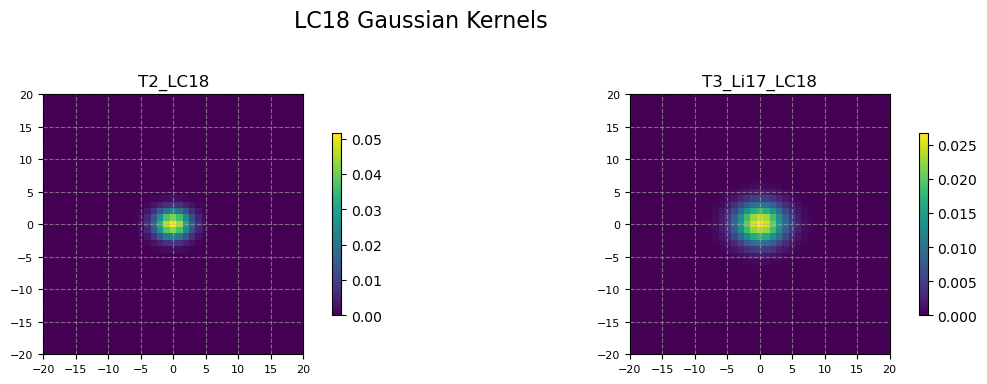

In [15]:
# LC18 Gaussian parameters
lc18_gaussian_params = {
    'T2_LC18': {'A': 0.02713970800096853, 'mu_x': -0.07179159144228903, 'mu_y': 0.018729988542747496, 
                'sigma_x': 2.795021455146342, 'sigma_y': 2.2096976215124475},
    'T3_Li17_LC18': {'A': 0.014359611113604268, 'mu_x': 0.029305314400791878, 'mu_y': -0.03595774162119623, 
                     'sigma_x': 3.848402648694555, 'sigma_y': 3.100030786420205}
}

# Generate Gaussian kernels for LC18
LC18_kernels = {name: create_gaussian_kernel_from_params(**params) for name, params in lc18_gaussian_params.items()}

# Plot the kernels
plot_gaussian_kernels(LC18_kernels, title="LC18 Gaussian Kernels", n_rows=1, n_cols=2)

In [16]:
LC18_results = {}

for size, L2_convolved_images in convolved_results['T2'].items():
    timesteps, height, width = L2_convolved_images.shape
    
    LC18_results[size] = np.zeros(timesteps)

    for t in range(timesteps):
        weighted_sum = (
            0.43 * np.sum((convolved_results['T2'][size][t]+convolved_results1['T2'][size][t]) * LC18_kernels['T2_LC18']) -
            0.17 * np.sum((convolved_results['T3'][size][t]+convolved_results1['T3'][size][t]) * LC18_kernels['T3_Li17_LC18'])
        )
        LC18_results[size][t] = weighted_sum


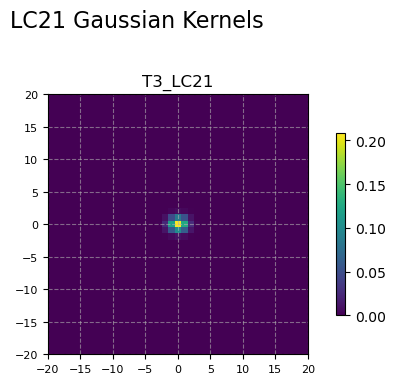

In [17]:

lc21_gaussian_params = {
    'T3_LC21': {'A': 0.09646828840280255, 'mu_x': 0.034449208808531404, 'mu_y': 0.0515986416703293, 
                  'sigma_x': 1.367642927650473, 'sigma_y': 1.115522701451049},
}

# Generate Gaussian kernels for LC21
LC21_kernels = {name: create_gaussian_kernel_from_params(**params) for name, params in lc21_gaussian_params.items()}

# Plot the kernels
plot_gaussian_kernels(LC21_kernels, title="LC21 Gaussian Kernels", n_rows=1, n_cols=1)


In [18]:
LC21_results = {}

for size, L2_convolved_images in convolved_results['T2'].items():
    timesteps, height, width = L2_convolved_images.shape
    
    LC21_results[size] = np.zeros(timesteps)

    for t in range(timesteps):
        weighted_sum = (
            0.21 * np.sum((convolved_results['T3'][size][t]+convolved_results1['T3'][size][t]) * LC21_kernels['T3_LC21'])
        )
        LC21_results[size][t] = weighted_sum

C:\Users\Administrator\AppData\Local\Temp\ipykernel_13800\3155318239.py:87: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.88, 1])  # 确保子图不被颜色条挤压


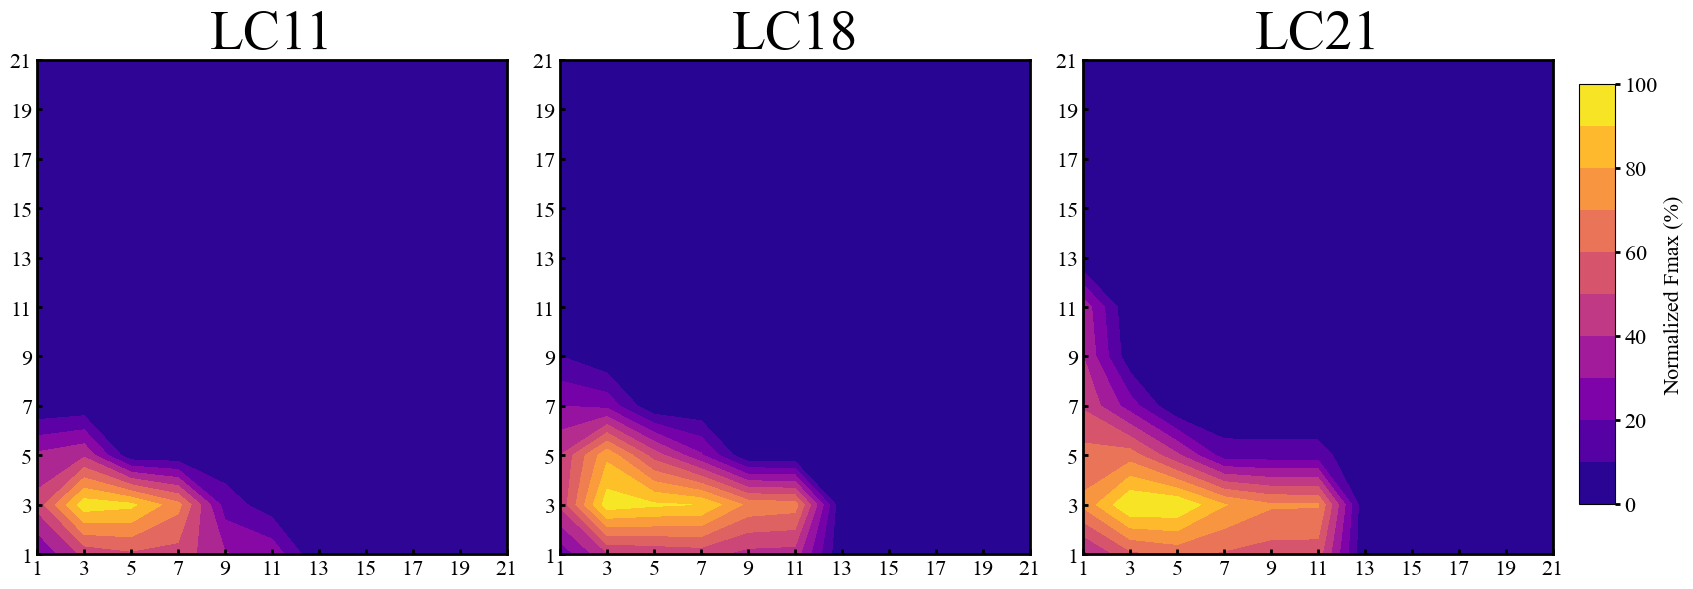

In [19]:
LC_results = {
    "LC11": LC11_results,
    "LC18": LC18_results,
    "LC21": LC21_results
}
heatmap_LC(LC_results)